# SGR SAOS: Frequency Sweeps and Phase Classification

> **What is SGR?** The Soft Glassy Rheology (SGR) model is a **statistical mechanics framework** for materials with disordered, metastable microstructures—foams, emulsions, pastes, colloidal gels. It treats the material as mesoscopic "elements" trapped in energy wells of depth $E$, with an effective **noise temperature** $x$ providing thermal-like kicks that enable rearrangements. This trap model produces a genuine **glass transition** at $x=1$, separating solid-like and fluid-like phases.

> **Handbook:** [SGR Conventional](../../docs/source/models/sgr/sgr_conventional.rst) • [SGR Generic](../../docs/source/models/sgr/sgr_generic.rst)

## Key Physics: Parallel Power-Law Scaling

For small-amplitude oscillatory shear (SAOS), SGR predicts the hallmark of soft glassy materials:

$$G'(\omega) \sim G''(\omega) \sim \omega^{x-1} \quad \text{for } 1 < x < 2$$

Both moduli show **parallel slopes** on log-log plots with **constant loss tangent** $\tan\delta = \tan(\pi(x-1)/2)$ — a unique signature absent in Maxwell-type models. This arises from the **power-law relaxation spectrum** $H(\tau) \propto \tau^{x-2}$ produced by the exponential trap distribution $\rho(E) = e^{-E}$.

**Phase-dependent behavior:**
- **$x < 1$** (glass): $G' \gg G''$, nearly frequency-independent plateau, solid-like
- **$1 < x < 2$** (soft glass): $G' \approx G''$, parallel power-law slopes, weak gel
- **$x \geq 2$** (Newtonian): $G'' \gg G'$, liquid-like with $G'' \sim \omega$

**Parameters**:
- $x$: Noise temperature — directly readable from $\log(G')$ vs $\log(\omega)$ slope
- $G_0$: Plateau modulus — sets high-frequency limit
- $\tau_0$: Microscopic time — sets frequency scale

## Learning Objectives

1. Fit SGR models to SAOS data (chia seed gel)
2. Extract phase classification from noise temperature $x$
3. Visualize power-law scaling $G' \sim G'' \sim \omega^{x-1}$
4. Compare SGRConventional and SGRGeneric
5. Analyze Cole-Cole plots for phase-space view
6. Perform Bayesian inference with NUTS

## Prerequisites

- Oscillatory rheology fundamentals ($G'$, $G''$, $\tan\delta$)
- Basic RheoJAX (`basic/01`)

## Runtime

- **Fast mode** (1 chain): ~2 min
- **Production** (4 chains): ~5 min

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
%matplotlib inline
import json
import os
import sys
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.sgr import SGRConventional, SGRGeneric

jax, jnp = safe_import_jax()
verify_float64()

FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
print(f"FAST_MODE: {FAST_MODE}")

JAX version: 0.8.3
Devices: [CpuDevice(id=0)]
FAST_MODE: True


In [3]:
def compute_fit_quality(y_true, y_pred):
    """Compute R² and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {"R2": r2, "RMSE": rmse}

## 2. Theory: SGR Oscillatory Response

For small-amplitude oscillatory shear (SAOS), the complex modulus is:

$$G^*(\omega) = G'(\omega) + iG''(\omega)$$

SGR predicts power-law scaling in the soft glass regime:

$$G'(\omega) \sim G''(\omega) \sim \omega^{x-1} \quad \text{for } 1 < x < 2$$

**Phase-dependent behavior:**

- **x < 1 (Glass):** $G' \gg G''$, nearly frequency-independent plateau, solid-like
- **1 < x < 2 (Soft Glass):** $G'$ and $G''$ both show power-law frequency dependence, weak gel
- **x ≥ 2 (Newtonian):** $G'' \gg G'$, liquid-like with $G'' \sim \omega$

The noise temperature **x** directly encodes the material phase and can be extracted from the slope of log(G') vs log(ω).

## 3. Load Data

In [4]:
# Load chia seed gel oscillation data
data_path = os.path.join("..", "data", "oscillation", "foods", "oscillation_chia_data.csv")
raw = np.loadtxt(data_path, delimiter=",", skiprows=1)
omega = raw[:, 0]           # Angular frequency [rad/s]
G_prime = raw[:, 1]         # Storage modulus [Pa]
G_double_prime = raw[:, 2]  # Loss modulus [Pa]

# Sort by frequency (ascending) if needed
sort_idx = np.argsort(omega)
omega = omega[sort_idx]
G_prime = G_prime[sort_idx]
G_double_prime = G_double_prime[sort_idx]

G_star = np.column_stack([G_prime, G_double_prime])

print(f"Data points: {len(omega)}")
print(f"Frequency range: {omega.min():.4f} – {omega.max():.1f} rad/s")
print(f"G' range: {G_prime.min():.1f} – {G_prime.max():.1f} Pa")
print(f"G'' range: {G_double_prime.min():.1f} – {G_double_prime.max():.1f} Pa")

Data points: 25
Frequency range: 0.0073 – 100.0 rad/s
G' range: 36.2 – 178.1 Pa
G'' range: 9.2 – 228.5 Pa


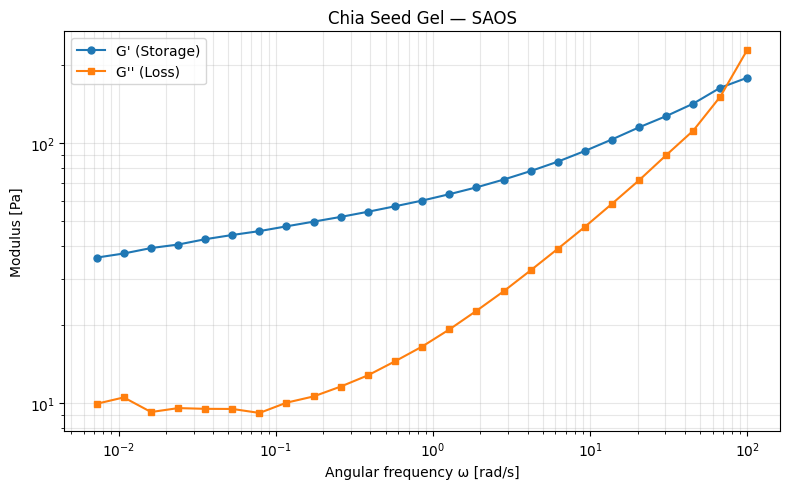

In [5]:
# Plot raw data
fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(omega, G_prime, "o-", markersize=5, label="G' (Storage)")
ax.loglog(omega, G_double_prime, "s-", markersize=5, label="G'' (Loss)")
ax.set_xlabel("Angular frequency ω [rad/s]")
ax.set_ylabel("Modulus [Pa]")
ax.set_title("Chia Seed Gel — SAOS")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

### 4.1 Fit to Chia Seed Gel

In [6]:
# NLSQ fit with SGRConventional
model = SGRConventional()

t0 = time.time()
model.fit(omega, G_star, test_mode="oscillation", method='scipy')
t_nlsq = time.time() - t0

# Compute fit quality
G_pred_fit = model.predict(omega)
metrics = compute_fit_quality(G_star, G_pred_fit)

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"R²: {metrics['R2']:.6f}")
print(f"RMSE: {metrics['RMSE']:.4g} Pa")
print("\nFitted parameters:")
for name in ["x", "G0", "tau0"]:
    val = model.parameters.get_value(name)
    print(f"  {name:5s} = {val:.4g}")
print(f"Phase regime: {model.get_phase_regime()}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.635440s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=28 | final_cost=1.0558 | elapsed=1.635s | final_gradient_norm=32.8760


NLSQ fit time: 2.59 s
R²: -0.034745
RMSE: 50.37 Pa

Fitted parameters:
  x     = 0.5
  G0    = 90.88
  tau0  = 590.1
Phase regime: glass


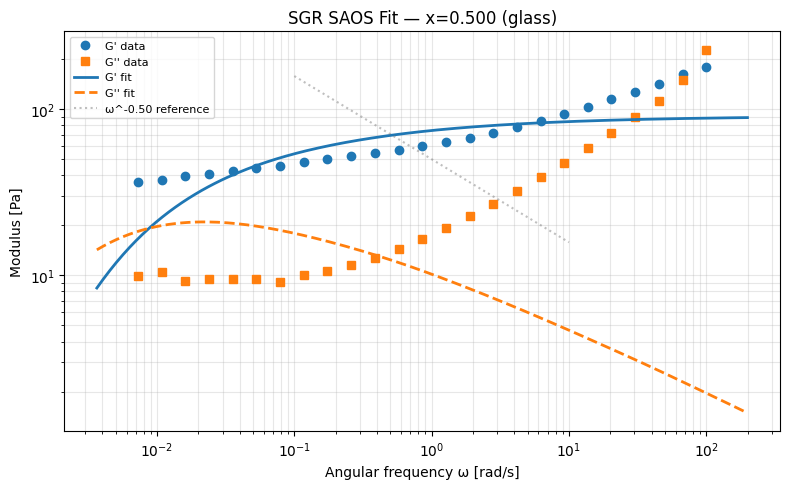

In [7]:
# Plot fit with power-law reference
omega_fine = np.logspace(np.log10(omega.min()) - 0.3, np.log10(omega.max()) + 0.3, 200)
G_pred = model.predict(omega_fine)

fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(omega, G_prime, "o", markersize=6, color="C0", label="G' data")
ax.loglog(omega, G_double_prime, "s", markersize=6, color="C1", label="G'' data")
ax.loglog(omega_fine, G_pred[:, 0], "-", lw=2, color="C0", label="G' fit")
ax.loglog(omega_fine, G_pred[:, 1], "--", lw=2, color="C1", label="G'' fit")

# Power-law reference
x_fit = model.parameters.get_value("x")
slope = x_fit - 1
ref_omega = np.logspace(-1, 1, 50)
ref_G = 50 * ref_omega ** slope
ax.loglog(ref_omega, ref_G, ":", lw=1.5, color="gray", alpha=0.5, label=f"ω^{slope:.2f} reference")

ax.set_xlabel("Angular frequency ω [rad/s]")
ax.set_ylabel("Modulus [Pa]")
ax.set_title(f"SGR SAOS Fit — x={x_fit:.3f} ({model.get_phase_regime()})")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

### 4.2 Phase Regime Exploration

Explore how G'(ω) and G''(ω) change across SGR phase regimes by predicting for different x values.

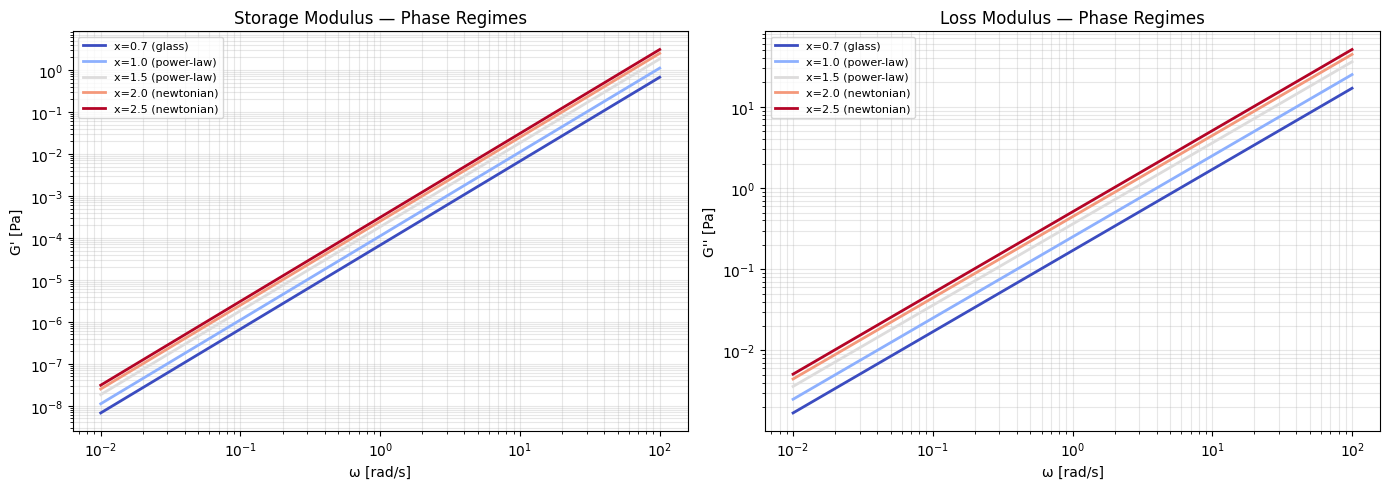

In [8]:
# Phase sweep predictions
x_values = [0.7, 1.0, 1.5, 2.0, 2.5]
omega_sweep = np.logspace(-2, 2, 200)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
colors = plt.cm.coolwarm(np.linspace(0, 1, len(x_values)))

for i, x_val in enumerate(x_values):
    m = SGRConventional()
    m.parameters.set_value("x", x_val)
    m.parameters.set_value("G0", 1000.0)
    m.parameters.set_value("tau0", 1e-3)
    m.fitted_ = True
    m._test_mode = "oscillation"
    
    G_sweep = m.predict(omega_sweep)
    regime = m.get_phase_regime()
    
    ax1.loglog(omega_sweep, G_sweep[:, 0], "-", color=colors[i], lw=2, label=f"x={x_val} ({regime})")
    ax2.loglog(omega_sweep, G_sweep[:, 1], "-", color=colors[i], lw=2, label=f"x={x_val} ({regime})")

ax1.set_xlabel("ω [rad/s]")
ax1.set_ylabel("G' [Pa]")
ax1.set_title("Storage Modulus — Phase Regimes")
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3, which="both")

ax2.set_xlabel("ω [rad/s]")
ax2.set_ylabel("G'' [Pa]")
ax2.set_title("Loss Modulus — Phase Regimes")
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

### 4.3 Material Classification Guide

| x Range | Phase | G' vs G'' | Material Examples |
|---------|-------|-----------|-------------------|
| x < 1 | Glass | G' >> G'', plateau | Dense pastes, aged gels |
| 1 < x < 1.5 | Soft glass | G' > G'', weak ω-dep | Foams, emulsions |
| 1.5 < x < 2 | Power-law | G' ~ G'' | Polymer solutions |
| x ≥ 2 | Newtonian | G'' >> G' | Simple liquids |

### 4.4 Cole-Cole Plot

The Cole-Cole plot (G' vs G'') provides a phase-space view of the viscoelastic response.

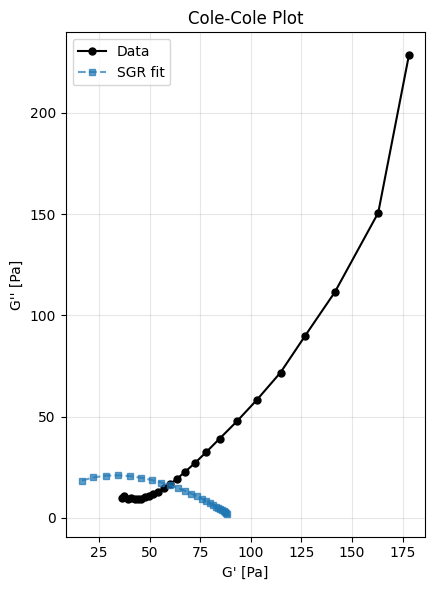

In [9]:
# Cole-Cole plot
fig, ax = plt.subplots(figsize=(7, 6))
ax.plot(G_prime, G_double_prime, "ko-", markersize=5, label="Data")

G_pred_data = model.predict(omega)
ax.plot(G_pred_data[:, 0], G_pred_data[:, 1], "s--", markersize=4, color="C0", alpha=0.7, label="SGR fit")

ax.set_xlabel("G' [Pa]")
ax.set_ylabel("G'' [Pa]")
ax.set_title("Cole-Cole Plot")
ax.set_aspect("equal")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

### 4.5 SGRGeneric Comparison

Compare SGRConventional with SGRGeneric (GENERIC framework with thermodynamic consistency).

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.665958s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=28 | final_cost=1.0558 | elapsed=0.666s | final_gradient_norm=32.8760


SGRConventional vs SGRGeneric:
  Conventional: x=0.5000, R²=-0.034745
  Generic:      x=0.5000, R²=-0.034745

Thermodynamic consistency: True


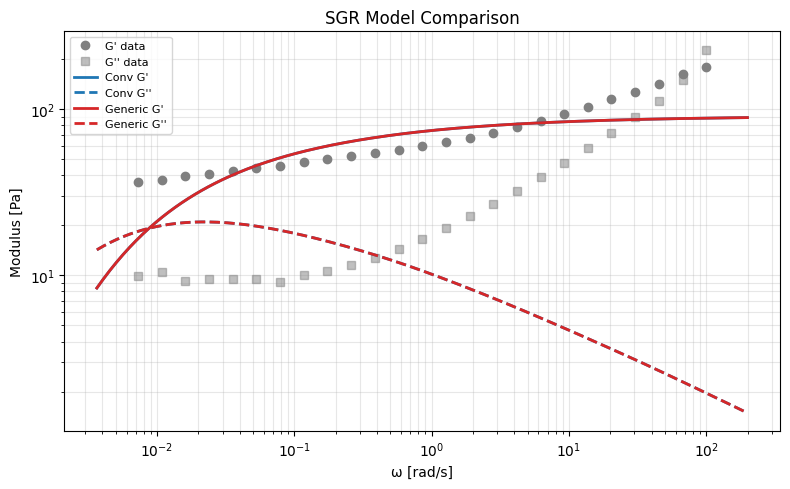

In [10]:
# SGRGeneric comparison
model_gen = SGRGeneric()
model_gen.fit(omega, G_star, test_mode="oscillation", method='scipy')

# Compute fit quality for both models
G_conv_fit = model.predict(omega)
G_gen_fit = model_gen.predict(omega)
metrics_conv = compute_fit_quality(G_star, G_conv_fit)
metrics_gen = compute_fit_quality(G_star, G_gen_fit)

print("SGRConventional vs SGRGeneric:")
print(f"  Conventional: x={model.parameters.get_value('x'):.4f}, R²={metrics_conv['R2']:.6f}")
print(f"  Generic:      x={model_gen.parameters.get_value('x'):.4f}, R²={metrics_gen['R2']:.6f}")

state = np.array([100.0, 0.5])
consistency = model_gen.verify_thermodynamic_consistency(state)
print(f"\nThermodynamic consistency: {consistency.get('thermodynamically_consistent', 'N/A')}")

G_gen_pred = model_gen.predict(omega_fine)

fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(omega, G_prime, "o", markersize=6, color="gray", label="G' data")
ax.loglog(omega, G_double_prime, "s", markersize=6, color="gray", alpha=0.5, label="G'' data")
ax.loglog(omega_fine, G_pred[:, 0], "-", lw=2, color="C0", label="Conv G'")
ax.loglog(omega_fine, G_pred[:, 1], "--", lw=2, color="C0", label="Conv G''")
ax.loglog(omega_fine, G_gen_pred[:, 0], "-", lw=2, color="C3", label="Generic G'")
ax.loglog(omega_fine, G_gen_pred[:, 1], "--", lw=2, color="C3", label="Generic G''")
ax.set_xlabel("ω [rad/s]")
ax.set_ylabel("Modulus [Pa]")
ax.set_title("SGR Model Comparison")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Bayesian Inference with NUTS

### 5.1 Run NUTS

Use NLSQ parameters as warm-start for Bayesian inference.

In [11]:
# Bayesian inference
initial_values = {name: model.parameters.get_value(name) for name in ["x", "G0", "tau0"]}
print("Warm-start values:", initial_values)

NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1
# NUM_WARMUP = 1000; NUM_SAMPLES = 2000; NUM_CHAINS = 4  # production

t0 = time.time()
result = model.fit_bayesian(
    omega, G_star, test_mode="oscillation",
    num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES, num_chains=NUM_CHAINS,
    initial_values=initial_values, seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Warm-start values: {'x': 0.5000000000046292, 'G0': 90.88021351925138, 'tau0': 590.0696565731527}


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<11:26,  1.02it/s, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:  12%|█▏        | 81/700 [00:01<00:06, 102.35it/s, 87 steps of size 4.27e-02. acc. prob=0.87]

warmup:  24%|██▎       | 166/700 [00:01<00:02, 216.79it/s, 15 steps of size 1.76e-01. acc. prob=0.88]

sample:  37%|███▋      | 261/700 [00:01<00:01, 348.13it/s, 15 steps of size 1.70e-01. acc. prob=0.95]

sample:  53%|█████▎    | 370/700 [00:01<00:00, 498.64it/s, 31 steps of size 1.70e-01. acc. prob=0.94]

sample:  69%|██████▊   | 480/700 [00:01<00:00, 633.87it/s, 31 steps of size 1.70e-01. acc. prob=0.94]

sample:  82%|████████▏ | 576/700 [00:01<00:00, 626.94it/s, 15 steps of size 1.70e-01. acc. prob=0.95]

sample:  99%|█████████▉| 692/700 [00:01<00:00, 750.93it/s, 15 steps of size 1.70e-01. acc. prob=0.95]

sample: 100%|██████████| 700/700 [00:01<00:00, 399.87it/s, 15 steps of size 1.70e-01. acc. prob=0.95]


Bayesian inference time: 4.4 s


### 5.2 Convergence Diagnostics

In [12]:
# Convergence diagnostics
diag = result.diagnostics
param_names = ["x", "G0", "tau0"]

print("Convergence Diagnostics")
print("=" * 50)
print(f"{'Parameter':>10s}  {'R-hat':>8s}  {'ESS':>8s}")
print("-" * 50)
for p in param_names:
    r_hat = diag.get("r_hat", {}).get(p, float("nan"))
    ess = diag.get("ess", {}).get(p, float("nan"))
    print(f"{p:>10s}  {r_hat:8.4f}  {ess:8.0f}")
n_div = diag.get("divergences", diag.get("num_divergences", 0))
print(f"\nDivergences: {n_div}")

Convergence Diagnostics
 Parameter     R-hat       ESS
--------------------------------------------------
         x    1.0089       127
        G0    0.9999       153
      tau0    1.0267       147

Divergences: 0


### 5.3 ArviZ Plots

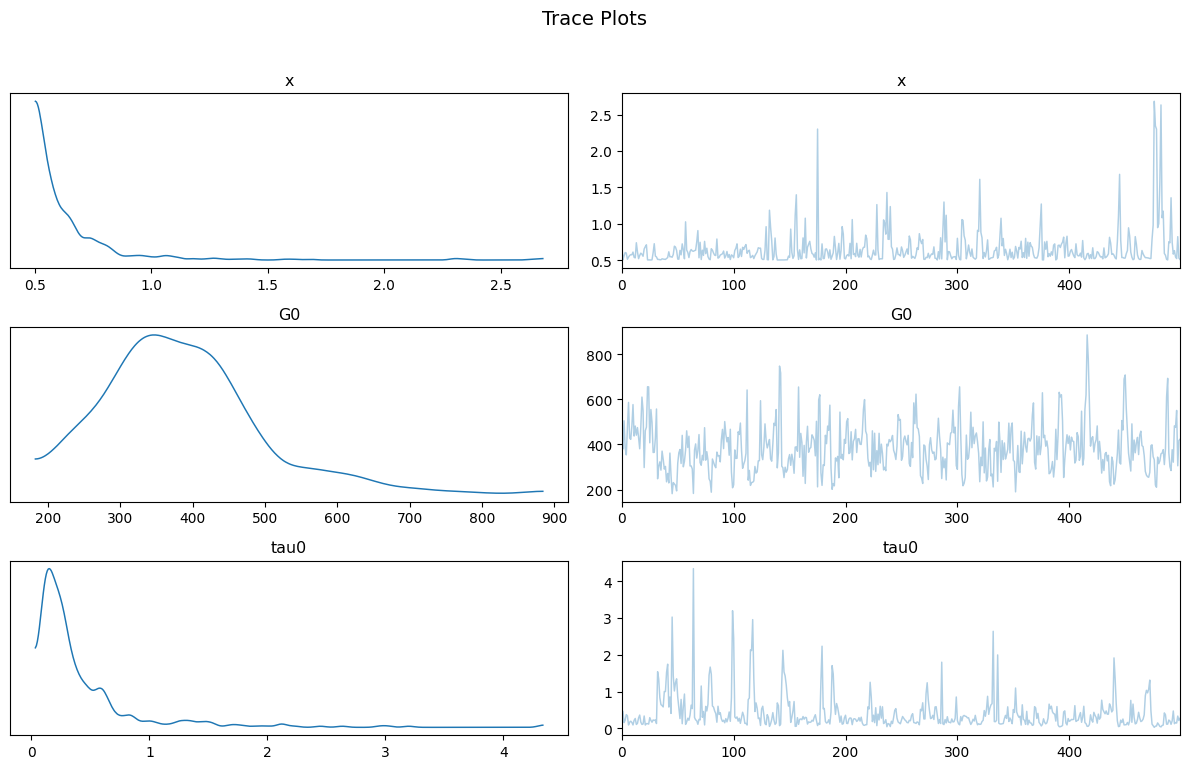

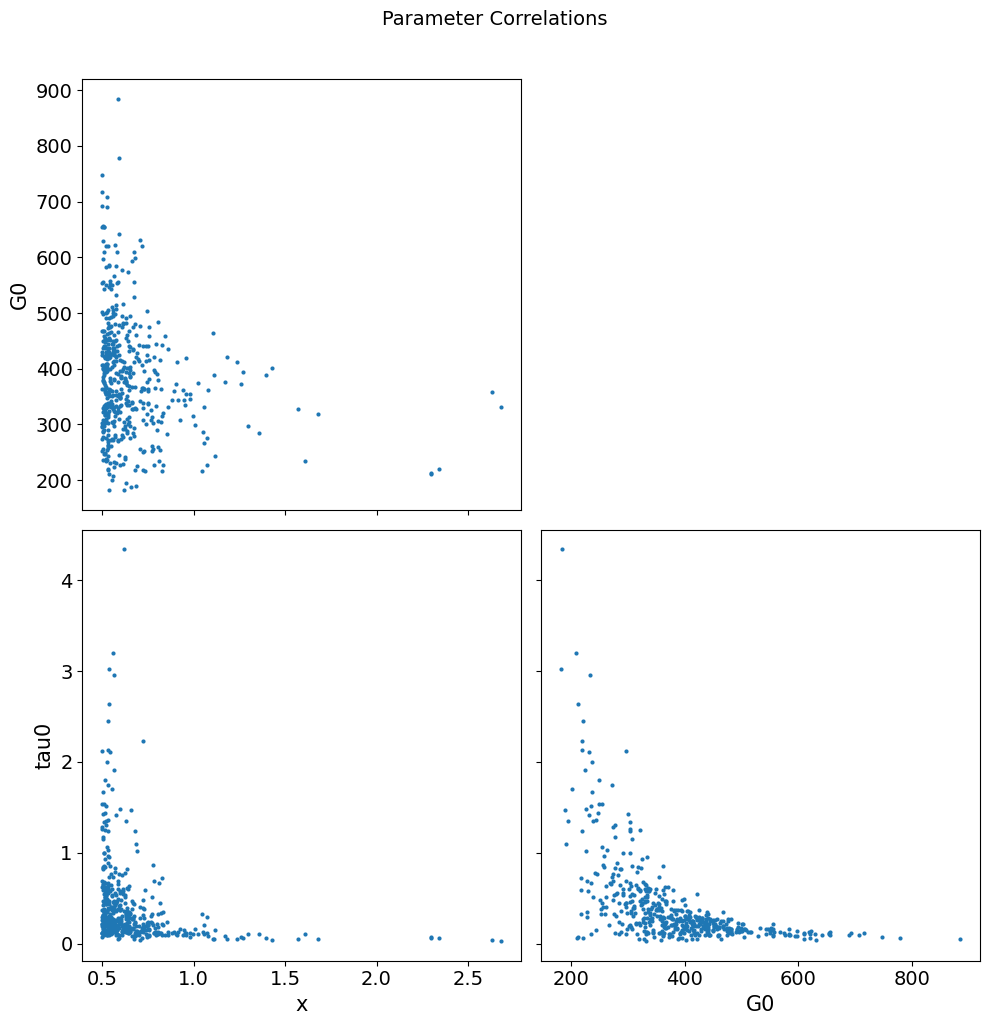

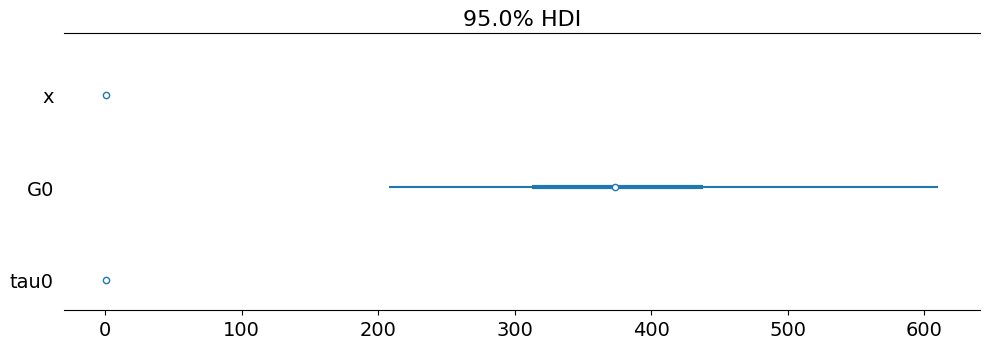

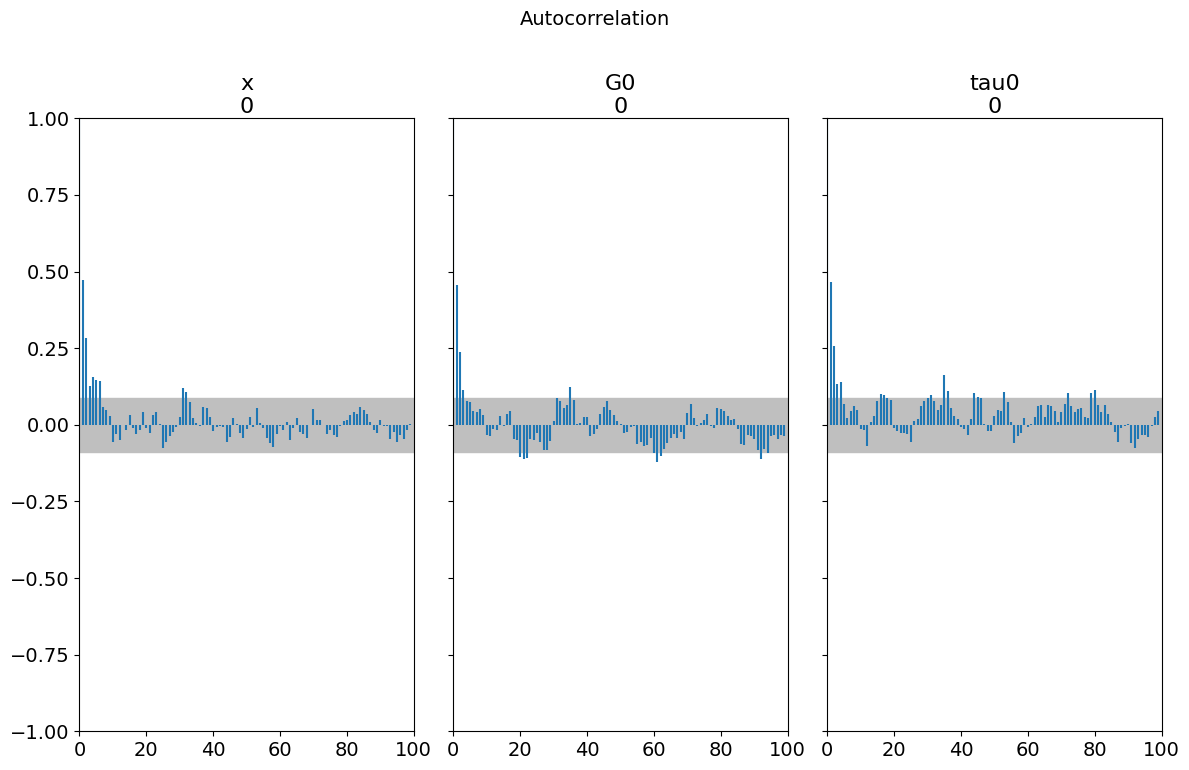

In [13]:
# ArviZ diagnostic plots (trace, pair, forest, energy, autocorrelation, rank)
param_names = ["x", "G0", "tau0"]
display_arviz_diagnostics(result, param_names, fast_mode=FAST_MODE)

### 5.4 Posterior Predictive

Generate posterior predictive distributions with 95% credible intervals.

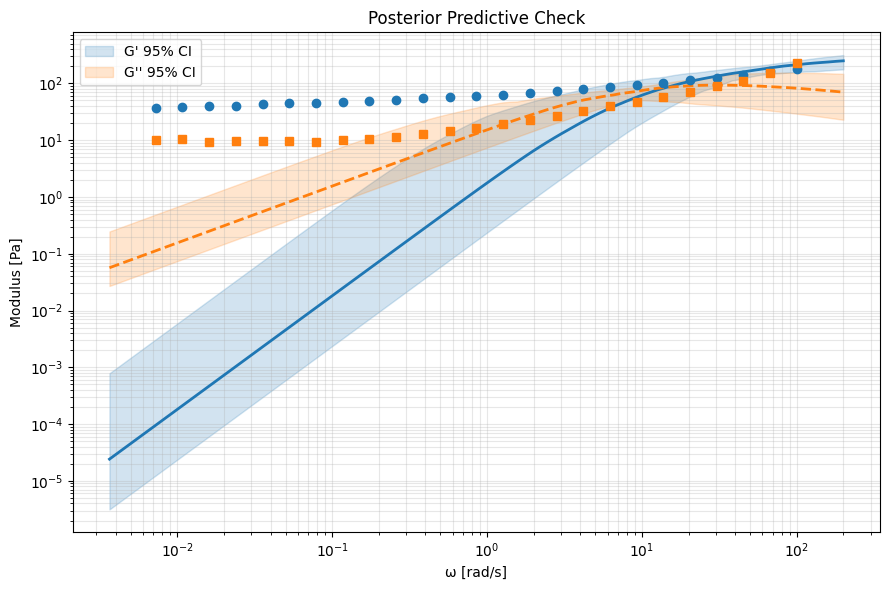

In [14]:
# Posterior predictive with CI bands
posterior = result.posterior_samples
n_draws = min(200, len(list(posterior.values())[0]))
omega_pred = np.logspace(np.log10(omega.min()) - 0.3, np.log10(omega.max()) + 0.3, 100)

pred_Gp = []
pred_Gpp = []
for i in range(n_draws):
    # Set parameters from posterior
    for name in ["x", "G0", "tau0"]:
        model.parameters.set_value(name, float(posterior[name][i]))
    pred_i = model.predict(omega_pred)
    pred_Gp.append(np.array(pred_i[:, 0]))
    pred_Gpp.append(np.array(pred_i[:, 1]))

pred_Gp = np.array(pred_Gp)
pred_Gpp = np.array(pred_Gpp)

fig, ax = plt.subplots(figsize=(9, 6))
ax.fill_between(omega_pred, np.percentile(pred_Gp, 2.5, axis=0), np.percentile(pred_Gp, 97.5, axis=0),
                alpha=0.2, color="C0", label="G' 95% CI")
ax.fill_between(omega_pred, np.percentile(pred_Gpp, 2.5, axis=0), np.percentile(pred_Gpp, 97.5, axis=0),
                alpha=0.2, color="C1", label="G'' 95% CI")
ax.loglog(omega_pred, np.median(pred_Gp, axis=0), "-", lw=2, color="C0")
ax.loglog(omega_pred, np.median(pred_Gpp, axis=0), "--", lw=2, color="C1")
ax.loglog(omega, G_prime, "o", color="C0", markersize=6)
ax.loglog(omega, G_double_prime, "s", color="C1", markersize=6)
ax.set_xlabel("ω [rad/s]")
ax.set_ylabel("Modulus [Pa]")
ax.set_title("Posterior Predictive Check")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 6. Save Results

In [15]:
# Save results
output_dir = os.path.join("..", "outputs", "sgr", "saos")
os.makedirs(output_dir, exist_ok=True)

nlsq_params = {name: float(model.parameters.get_value(name)) for name in ["x", "G0", "tau0"]}
with open(os.path.join(output_dir, "nlsq_params.json"), "w") as f:
    json.dump(nlsq_params, f, indent=2)

posterior_dict = {k: np.array(v).tolist() for k, v in posterior.items()}
with open(os.path.join(output_dir, "posterior_samples.json"), "w") as f:
    json.dump(posterior_dict, f)

print(f"Results saved to {output_dir}/")

Results saved to ../outputs/sgr/saos/


## Further Reading

- [SGR Conventional Handbook](../../docs/source/models/sgr/sgr_conventional.rst)
- [SGR Generic Handbook](../../docs/source/models/sgr/sgr_generic.rst)
- Sollich, P. (1998). Rheological constitutive equation for a model of soft glassy materials. *Phys. Rev. E*, 58, 738–759.
- Mason, T.G. & Weitz, D.A. (1995). Linear viscoelasticity of colloidal hard-sphere suspensions near the glass-transition. *Phys. Rev. Lett.*, 75, 2770–2773.

## Next Steps

- **NB 02**: Relaxation — time-domain view of the same power-law dynamics ($G(t) \sim t^{1-x}$)
- **NB 04**: Creep — complementary compliance protocol ($J(t) \sim t^{x-1}$)
- **NB 01**: Flow curves — steady shear viscosity $\eta \sim \dot{\gamma}^{x-2}$
- **NB 06**: LAOS — nonlinear yielding at large amplitudes